# Stereovision

![Suzanne](main.png)

Stereovision is a discipline that deals with the reconstruction of 3D information from images. For the reconstruction of a point, several images of this point are needed. These images must be taken from different points of view. The key step of the reconstruction, which is often problematic, is to identify the images of the point to be reconstructed in each view.

## Epipolar Geometry

Epipolar geometry involves two cameras. The epipolar geometry describes the geometric properties between two views of the same scene and depends only on the intrinsic parameters of the cameras and their relative positions. It provides, in particular, the epipolar constraint, which will be very useful to produce the matches between views.

## The Fondamental Matrix

![Epipolar Geometry - Sanyam Kapoor](epipolar.png)

Let us imagine that we have two images, right and left, of the world space. Let's take a point $\vec{x}$ in the right image space. The point $\vec{X}$ of the world space, of which $\vec{x}$ is the image, can be anywhere on the line passing through $\vec{x}$ and the optical center of the right camera. We will call this line the back-projected ray of $\vec{x}$. Let us note $\vec{x}'$ the image of $\vec{X}$ in the left image space. The locus of $\vec{x}'$ is therefore the image line of the back-projected ray of $\vec{x}$. This line is called the epipolar line and is denoted $\vec{l}'$. The epipolar line passes through the epipole $\vec{e}'$, image of the optical center of the right camera.

In 2D projective geometry, a line with equation $ax+by+c = 0$ is represented by a vector with three components $(a, b, c)^T$ defined to within one factor. Thus, we have the following relationship:

>The point $\vec{x}$ belongs to the line $\vec{l}$ if and only if $x^T\vec{l} = 0$.

Moreover, in 2D projective geometry, the following remarkable relations are valid:

- The intersection of two lines $l$ and $l'$ is given by $x = l \times l'$,
- The line passing through two points $x$ and $x'$ is given by $l = x \times x'$.

Note that the vector product can be written as a product of matrix $x \times y = [x]_\times y$ where

$$[x]_\times = \begin{pmatrix} 0 & ‚àíx3 & x2 \\ x3 & 0 & ‚àíx1 \\ ‚àíx2 & x1 & 0 \end{pmatrix}$$

To find the equation of the epipolar line in the left image space, we just need to find the coordinates of two points of this line. The first is the image $P'\vec{C}$ of the optical center $\vec{C}$ of the right camera where $P'$ is the projection matrix of the left camera. The second is $P'P^{+}\vec{x}$ where $P^{+}$ is the pseudo inverse of the projection matrix $P$ of the right camera. The epipolar line thus has the equation $l' = [P'\vec{C}]_\times{}P'P^{+}\vec{x} = F\vec{x}$ with $F = [P'\vec{C}]_\times{}P'P^{+}$. $F$ is called fundamental matrix.

Since the epipolar line $\vec{l}' = F\vec{x}$ is the locus of $\vec{x}'$, $\vec{x}'$ therefore belongs to $\vec{l}'$ which leads to the epipolar constraint :

>**The fundamental matrix is such that for any pair of points corresponding $\vec{x} \leftrightarrow \vec{x}'$ in the two images, we have $\vec{x}'^{T}F\vec{x} = 0$.**

## Computation of the fundamental matrix

The fundamental matrix $F$ has seven degrees of freedom. It has nine components but these are defined to within one scale factor, which removes one degree of freedom. Moreover, the matrix $F$ is a singular matrix ($det(F) = 0$) which gives us seven degrees of freedom. So we need at least seven correspondences to compute $F$. The equation $x'^{T}_iFx_i = 0$ and the seven correspondences allow us to write a system of equations of the form $Af = 0$, where $f$ is the vector which contains the components of the matrix $F$. Let us assume that $A$ is a 7√ó9 matrix of rank 7. The general solution of $Af = 0$ can be written $\alpha f_1 + (1-\alpha) f_2$ where $f_1$ and $f_2$ are two particular independent solutions of $Af = 0$. We then use the singularity constraint $det(\alpha F_1 + (1 - \alpha)F_2) = 0$ to determine $\alpha$. Since the singularity constraint gives rise to a third degree equation, we may have one or three solutions for $F$.

## OpenCV

In practice you will use the OpenCV library. In python, you have access to its functions through the `cv2` module.

You can find help with the calibration and reconstruction functions on the site https://docs.opencv.org/4.0.0/d9/d0c/group__calib3d.html

## Goal

In the zip of the statement you will find two sequences of images taken by two cameras during the scanning of an object by a laser plane.

![Laser](scanRight/scan0010.png)

You will also find shots of a checkerboard in different positions that will help you calibrate your cameras.

![Damier](chessboards/c2Right.png)

The goal is to reconstruct the scanned object in 3D.

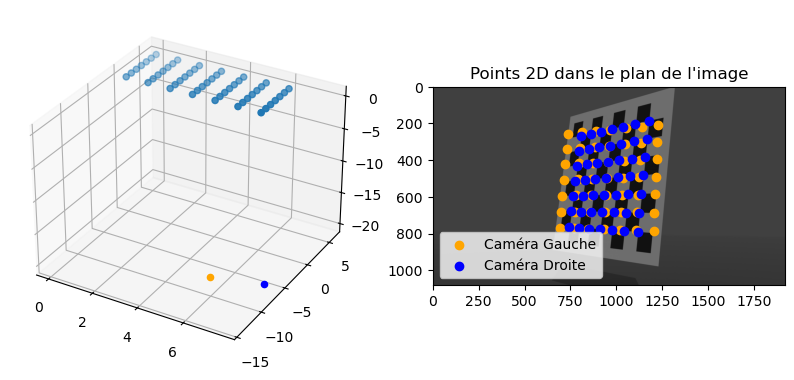

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2 as cv
import glob

# criteria : D√©finit les crit√®res d'arr√™t utilis√©s par la fonction de raffinement cv.cornerSubPix.
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001) #pour ameliorer la precision de la position des coins

# objp : Initialise une matrice pour contenir les coordonn√©es 3D de points sur le damier (coins).
objp = np.zeros((7*7, 3), np.float32) #mattrice (49,3) pour stocker valeurs des points du damier en 3d
objp[:, :2] = np.mgrid[0:7, 0:7].T.reshape(-1, 2) #mattrice (49,2) pour stocker valeurs des points du damier en 2d o√π on prend que les valeurs en x et en y

# objpoints et imgpoints : Listes vides pour stocker respectivement 
# les coordonn√©es 3D des points r√©els et les coordonn√©es 2D des points dans l'image.
objpoints = [] #3d
imgpoints = [] #2d

# Boucle √† travers les images du damier. Lit chaque image, convertit en niveaux de gris (gray).
for fname in glob.glob('chessboards/c2*.png'):
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Trouver les coins du damier
    ret, corners = cv.findChessboardCorners(gray, (7, 7), None) #Utilise la fonction cv.findChessboardCorners pour d√©tecter les coins du damier. Si les coins sont trouv√©s (ret est True) 
    if ret:
        # Raffiner les coins pour une meilleure pr√©cision
        corners2 = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria) # utilise ensuite cv.cornerSubPix pour raffiner les positions des coins.
        objpoints.append(objp) 
        imgpoints.append(corners2)
        #cv2.imshow('Chessboard corners', img)

# Applique la calibration de la cam√©ra en utilisant la fonction cv.calibrateCamera. ret true or false
#Renvoie la matrice de la cam√©ra (mtx), les coefficients de distorsion (dist) qui mod√©lisent les d√©fauts optiques de la lentille.,
# les vecteurs de rotation (rvecs) -> Pint, et les vecteurs de translation Une liste de vecteurs de translation pour chaque image, 
#repr√©sentant la position de la cam√©ra par rapport au syst√®me de coordonn√©es du monde 
#(tvecs) -> T
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Convertit les vecteurs de rotation en matrices de rotation √† l'aide de la fonction cv.Rodrigues. -> R
rmatRight = cv.Rodrigues(rvecs[0])[0]
rmatLeft = cv.Rodrigues(rvecs[1])[0]

# Cr√©e les matrices de rotation et de translation (matrices extrins√®ques) pour chaque cam√©ra.
rotMatRight = np.concatenate((rmatRight, tvecs[0]), axis=1) #il faut les combiner (rot et translation) pour connaitre √† la fois la position de la cam et son orientation de viser
rotMatLeft = np.concatenate((rmatLeft, tvecs[1]), axis=1)

# Calcule les matrices de cam√©ra en multipliant la matrice intrins√®que (mtx) par la matrice extrins√®que.
camLeft = mtx @ rotMatLeft
camRight = mtx @ rotMatRight

# Calcule le centre de projection de chaque cam√©ra dans le monde en inversant la matrice extrins√®que
# et en multipliant par les coordonn√©es homog√®nes [0, 0, 0, 1].
camWorldCenterLeft = np.linalg.inv(np.concatenate((rotMatLeft, [[0, 0, 0, 1]]), axis=0)) @ np.transpose([[0, 0, 0, 1]])
camWorldCenterRight = np.linalg.inv(np.concatenate((rotMatRight, [[0, 0, 0, 1]]), axis=0)) @ np.transpose([[0, 0, 0, 1]])

def plotDotWorld():
    fig = plt.figure(figsize=(10, 5))
    
    # Affichage des points 3D de l'objet
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter3D(objp[:, 0], objp[:, 1], objp[:, 2])
    ax1.scatter(camWorldCenterLeft[0], camWorldCenterLeft[1], camWorldCenterLeft[2], c='orange', marker='o')
    ax1.scatter(camWorldCenterRight[0], camWorldCenterRight[1], camWorldCenterRight[2], c='b', marker='o')
    
    # Affichage des points 2D dans le plan de l'image
    ax2 = fig.add_subplot(122)
    ax2.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))  # Affichage de l'image
    ax2.scatter(imgpoints[0][:, 0, 0], imgpoints[0][:, 0, 1], c='orange', marker='o', label='Cam√©ra Gauche')
    ax2.scatter(imgpoints[1][:, 0, 0], imgpoints[1][:, 0, 1], c='b', marker='o', label='Cam√©ra Droite')
    ax2.set_title("Points 2D dans le plan de l'image")
    ax2.legend()
    
    plt.show()

plotDotWorld()

mask
4.10.0


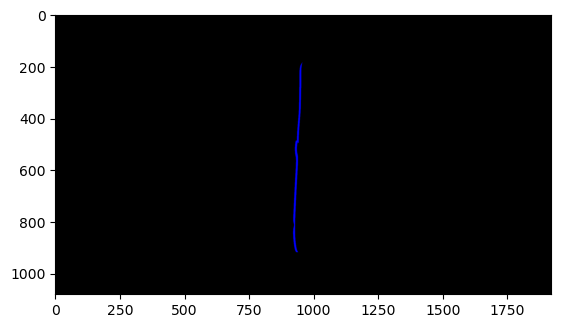

In [4]:
#sert juste a afficher le r√©sultat de getImgLine(fname) une fois    
img = cv.imread("scanRight/scan0012.png")                                      #stocke l'image dans une variable
ret, mask = cv.threshold(img,127,255,cv.THRESH_TOZERO)                         #on enleve tout ce qui a une intensit√© inf√©rieur √† 127 et on garde
#que ce qui a une intensit√© entre 127 et 255 (valeur max) afin de filtrer image pour garder que une ligne
print("mask")
plt.imshow(mask)   

#on a reussi a prendre une ligne, si on prend toutes les lignes de tout les scans on pourra reconstruire

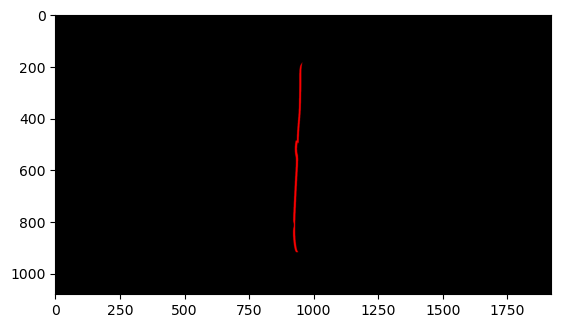

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def filter_red_color(image):
    # Convertir l'image en espace de couleur HSV car plus facile pour analyser pour cv l'image
    hsv_image = cv.cvtColor(image, cv.COLOR_BGR2HSV)

    # Plage de teintes pour le rouge (0-30 et 150-180) valeur du rouge
    #de 100 √† 255 de saturation pour eviter que ce soit trop desatur√©, et de 100 √† 255 de value pour eviter les rouges trop sombre
    lower_red = np.array([0, 100, 100])
    upper_red = np.array([30, 255, 255])
    lower_red2 = np.array([150, 100, 100])
    upper_red2 = np.array([180, 255, 255])

    # Cr√©er un masque pour les pixels rouges
    mask1 = cv.inRange(hsv_image, lower_red, upper_red) #creer masque binaire pour avoir en blanc les pixel qui correspond au filtre et en noir ceux qui correspondent pas
    mask2 = cv.inRange(hsv_image, lower_red2, upper_red2)

    # Combinez les deux masques pour avoir toutes les teintes de rouge des deux masques en blanc sur une image et le reste en noir
    mask = cv.bitwise_or(mask1, mask2)

    # Appliquer le masque √† l'image d'origine pour avoir que la ligne 
    result = cv.bitwise_and(image, image, mask=mask)

    return result

# Charger l'image
img = cv.imread("scanRight/scan0012.png")

# Appliquer le filtrage des pixels rouges
filtered_image = filter_red_color(img)

# Afficher l'image filtr√©e
plt.imshow(cv.cvtColor(filtered_image, cv.COLOR_BGR2RGB))
plt.show()


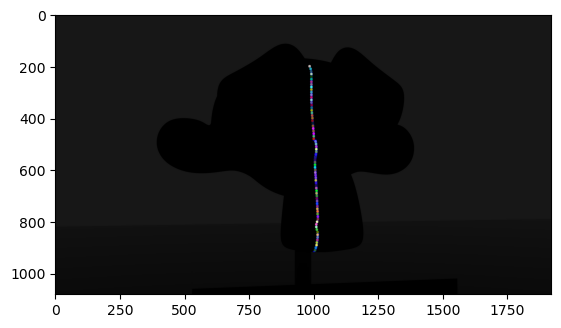

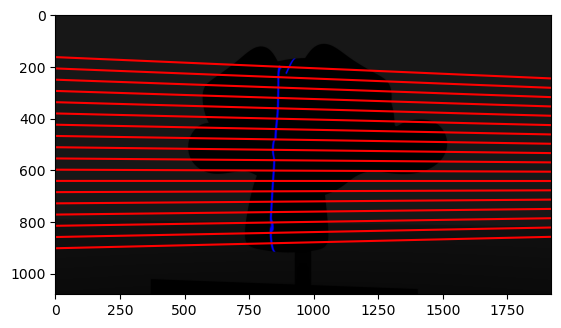

In [7]:
# Cette fonction prend un vecteur v en entr√©e et renvoie sa matrice de croix associ√©e.
# La matrice de croix est utilis√©e dans la triangulation st√©r√©o.
def crossMat(v):
    # Soit                          V = [[xxx][yyyy][zzzz]]
    v = v[:,0]    # qui donne donc  V = [xxx yyyy zzzz]               
            # Et on  retourne   ([[0000  -zzzz    yyyy]
            #                   [zzzz   0000   -xxxx]
            #                   [-yyyy  xxxx    0000]])

    return np.array([[0,-v[2],v[1]] , [v[2],0,-v[0]] , [-v[1],v[0],0]]) #cela permet de calculer le produit vectoriel comme une simple multiplication de matrice

# Cette fonction calcule la matrice fondamentale en utilisant les matrices de projection des cam√©ras gauche et droite, 
# ainsi que le centre de projection de la cam√©ra droite dans le syst√®me de coordonn√©es du monde.
def matFondamental(camLeft,centerRight,camRight): #objectif calculer la matrice fondamental utilis√© pour l'appariement des points elle relie les coordon√© d'un point d'une image avec celles d'une autre image
        # pseudo inverse de la matrice camRight, qu'on multiplie par camLeft (= MatriceIntrins√®que @ MatriceRota)
        # qu'on multiplie ensuite par (camLeft @centerRight) qui repr√©sente la matrice asym√©trique pour ce vecteur qui capture la g√©ometrie du point
        # Et on fait finalement le cross product (produit vectoriel) de la matrice colonne resultat
        return np.array(crossMat(camLeft @ centerRight) @ camLeft @ np.linalg.pinv(camRight)) #matrice fondamental etabli relation entre les points correspondant de l'image gauche et droite


#Produit matriciel : camLeft @ centerRight repr√©sente la projection du centre de la cam√©ra droite sur l'image gauche.
#Matrice de croix : Le produit crossMat(camLeft @ centerRight) produit la matrice antisym√©trique pour ce vecteur, qui capture la g√©om√©trie du point.
#Pseudo-inverse de camRight : np.linalg.pinv(camRight) est la pseudo-inverse de la matrice de projection de la cam√©ra droite, n√©cessaire pour obtenir une relation lin√©aire entre les images st√©r√©o.
#Le produit final produit la matrice fondamentale, qui est utilis√©e pour √©tablir la relation entre les points correspondants dans les images gauche et droite.

# Cette fonction prend en entr√©e le nom d'un fichier image, extrait le canal rouge et
# applique un seuillage pour cr√©er un masque qui ne conserve que la partie rouge de l'image.
def getImgLine(fname):              
    img = cv.imread(fname)                                      #stocke l'image dans une variable
    red = img[:,:,2]                                            #concr√®tement √ßa √©vite une erreur dans epiLine qui svt attend des images binaire et non rgb
    ret, mask = cv.threshold(red,127,255,cv.THRESH_TOZERO)      #vire tout ce qui n'est pas la ligne rouge
    return mask
    
# Cette fonction prend en entr√©e un chemin d'acc√®s et cherche les √©pilignes (lignes √©pipolaires)
# pour chaque image dans ce chemin en utilisant la matrice fondamentale
# Chaque point dans l'image gauche est projet√© sur un plan √©pipolaire dans l'image droite, et vice versa.
# Les lignes √©pipolaires sont ainsi cr√©√©es en intersectant le plan image avec les plans image de l'autre cam√©ra
# Ces lignes sont utiles dans la correspondance st√©r√©o, o√π l'on cherche √† associer des points dans une image √† leurs correspondants dans l'autre image.
def findEpilines(path):
    epilines = []
    # (la boucle for traverse les images)
    for l in range(26):                                 #On a 25 images, donc pour chaque image
        if l<10:
            strp = path + '000' + str(l) +'.png'
        else:
            strp = path + '00' + str(l) +'.png'
            
        ImgLine = getImgLine(strp)                      #On transforme l'image en un fond avec simplement la ligne de gard√©e
        pointsLeft = [[],[],[]] #cree un vecteur de coordon√©es de point de l'image gauche coordon√©es X, Y et representation en coordon√©es homog√®nes

        for index, line in enumerate(ImgLine):              # on prends l'index de la ligne et la ligne correspondante
            for pixel in line:                              # pour chaque pixel de la ligne
                if pixel != 0:                              # si le pixel n'est pas nul (vu qu'on a vir√© tout le reste pr√©c√©demment)
                    pixel = 1                               # sa valeur vaut 1
            try:
                pointsLeft[0].append(np.average(range(1920), weights = line))   # avg = sum(a * weights) / sum(weights)
                #on fait la moyenne de tout les points non nul donc en rouge pour trouver sa valeur en x
                pointsLeft[1].append(index)                                     # index de la ligne
                pointsLeft[2].append(1)                                         # coord homog√®nes
                #La derni√®re coordonn√©e est fix√©e √† 1 pour conserver la forme homog√®ne des points, n√©cessaire pour certains calculs matriciels
            except:
                pass
            
        epilinesRight = Fondamental @ pointsLeft            # la matrice fondamentale est utilis√©e pour projeter les points de l'image gauche sur l'image droite.
        epilines.append([pointsLeft, epilinesRight])        # on stock pour cette image les pointsLeft et les epilinesRight ce qui cr√©e les lignes √©pipolaires (je pense)
    return epilines

#La matrice fondamentale est une matrice qui encode la relation g√©om√©trique entre les points correspondants dans les deux images. Si un point 
#ùë•
#x dans l'image gauche est connu, la matrice fondamentale permet de calculer la ligne √©pipolaire dans l'image droite, sur laquelle se trouve son correspondant.
#ligne √©pipolaire est une ligne qui relie les points de l'image gauche par exemple et le point de l'image droite se trouvera forcement quelque part sur la ligne √©pipolaire

Fondamental = matFondamental(camRight,camWorldCenterLeft,camLeft)
# epl = [ [ [Red_x_avg], [Y_avg],¬†[1] ], [EpilineRight(i)] ] ]
# La fonction findEpilines est appel√©e pour obtenir les √©pilignes pour les images dans le dossier 'scanLeft/'
epl = findEpilines('scanLeft/')
#La variable epl contient les points moyens d√©tect√©s dans l'image gauche et les lignes √©pipolaires correspondantes dans l'image droite.

# Cette fonction prend le nom d'une image et les points de gauche (x moyens) pour cette image et les dessine sur l'image.
def drawAvgPoint(fname,EplLeft):                                                    # Cette fonction affiche les points de la ligne laser, input le nom de l'img et les pointsLeft de l'img
    img = cv.imread(fname)                                                          # 
    i = 0
    while i< len(EplLeft[0]):                                                       # Tant qu'il y a des "avg" qui n'ont pas √©t√© couverts
        color = tuple(np.random.randint(0,255,3).tolist())                          #
        img = cv.circle(img,(int(EplLeft[0][i]),int(EplLeft[1][i])),5,color,-1)     #
        i += 10                                                                     #
    plt.imshow(img)                                                                 # On affiche l'image modifi√©e
    plt.show()      

# Cette fonction calcule y pour une ligne donn√©e (repr√©sent√©e par ses coefficients) et une valeur de 
# x. Elle est utilis√©e pour dessiner les √©pilignes.
def lineY(coef, x): # pour trouver y en fonction de x et de abc car ax+by+c=0
    a, b, c = coef
    return -(c + a * x) / b


def drawEpl(fname,EplRight):
    img = cv.imread(fname)
    coef , length = EplRight.shape #Les lignes √©pipolaires sont repr√©sent√©es par des coefficients de la forme a,b et c pour chaque √©piligne
    for i in range(0,length,40):
        #print(EplRight[:,i])
        plt.plot([0,1919],[lineY(EplRight[:,i],0),lineY(EplRight[:,i],1919)],'r')
        
    plt.imshow(img)
    plt.show()

drawAvgPoint('scanLeft/0013.png',epl[13][0])
drawEpl('scanRight/scan0013.png',epl[13][1])
#epl[13][0] epl left , epl[13][1] epl right

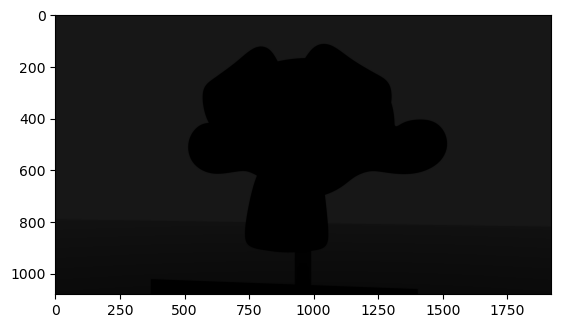

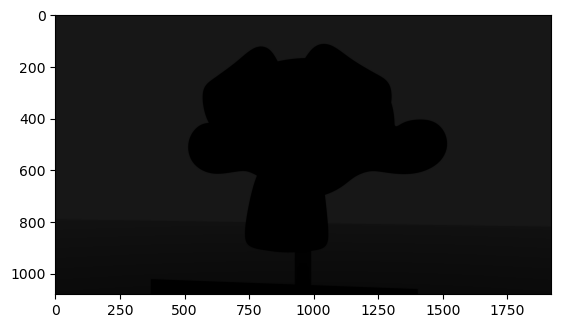

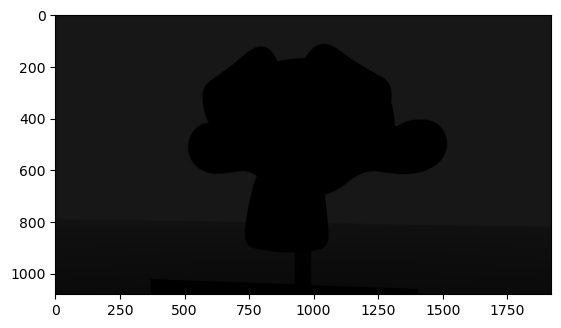

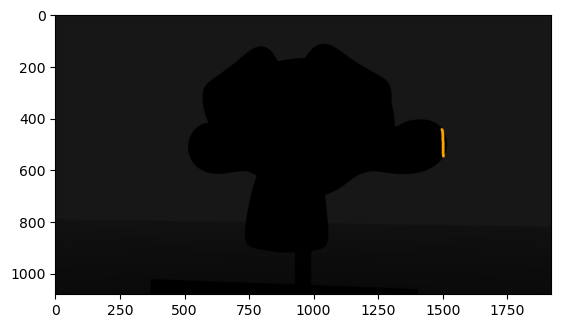

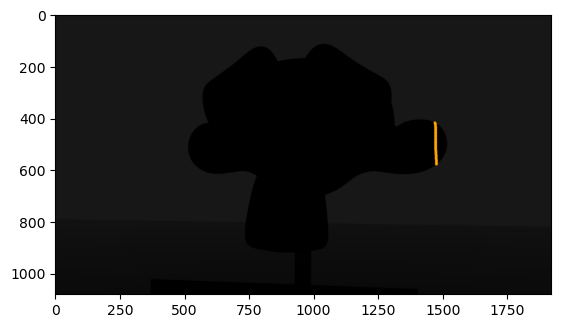

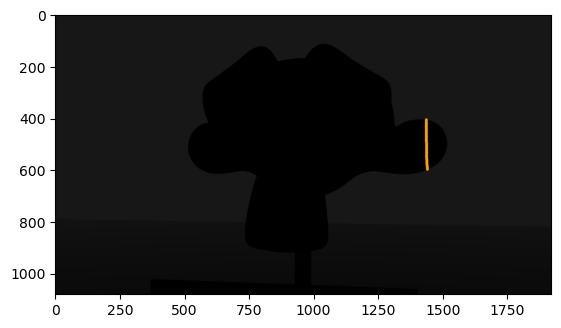

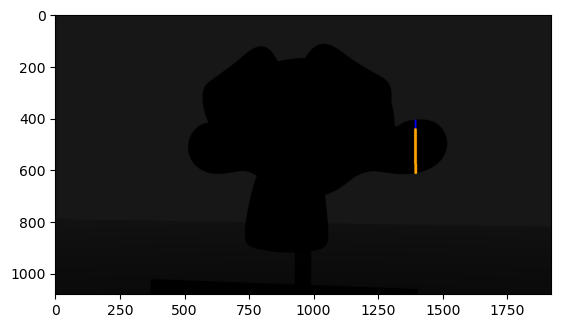

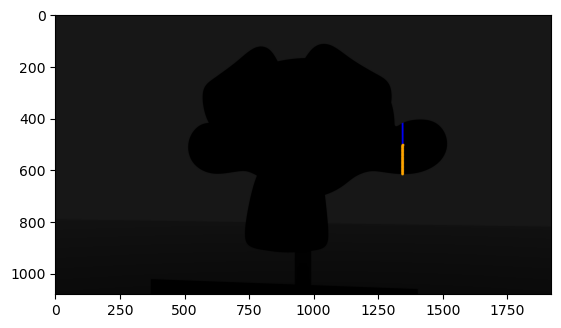

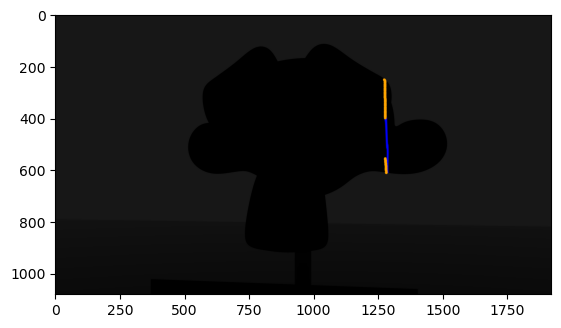

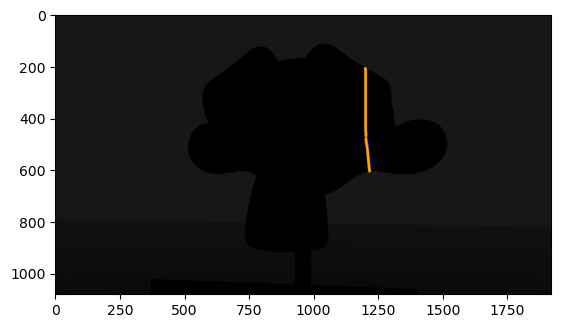

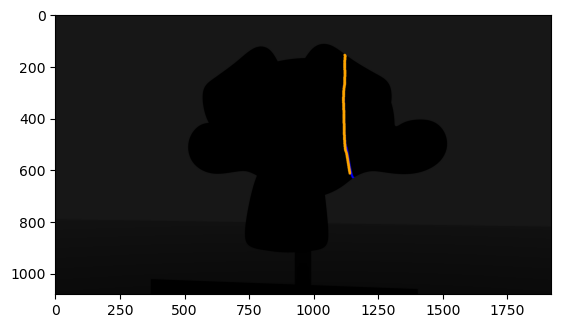

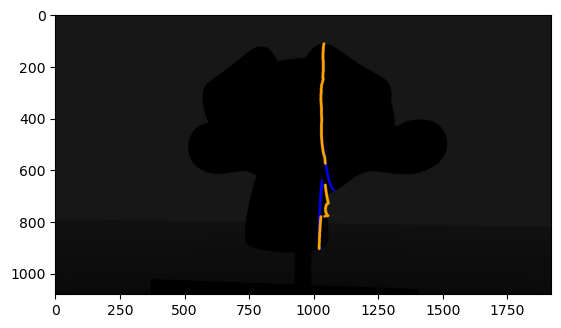

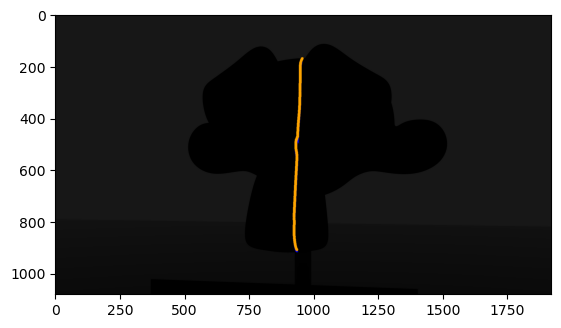

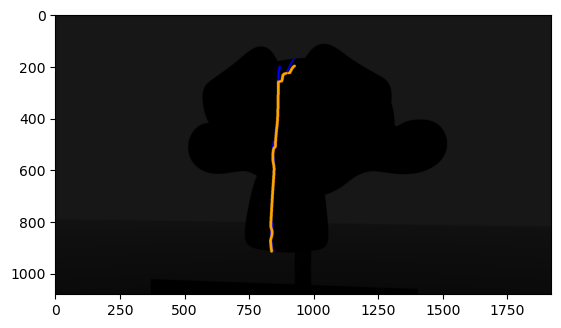

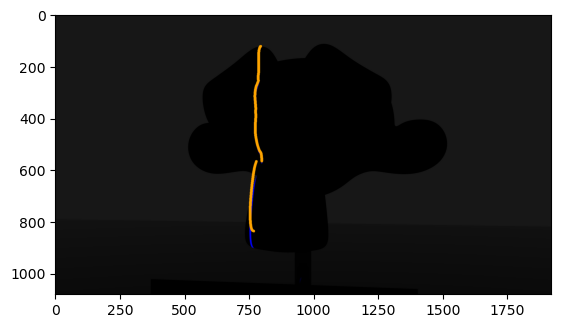

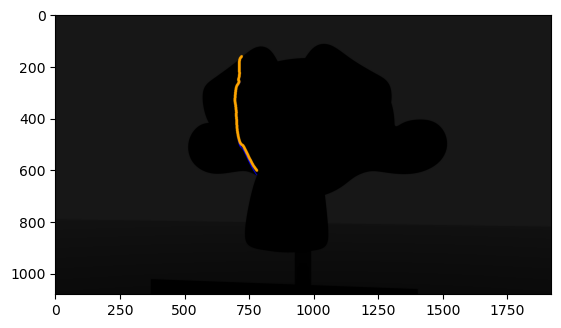

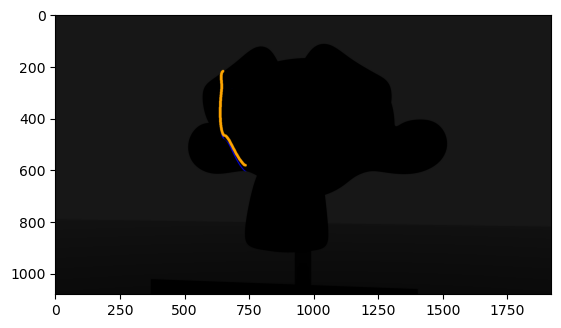

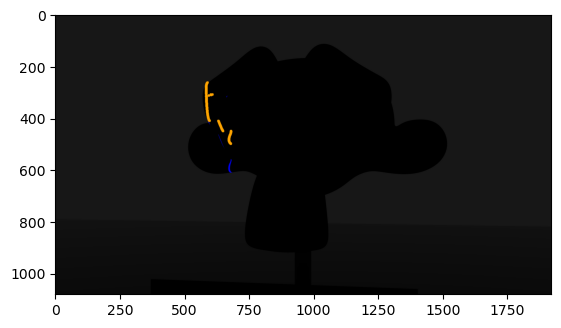

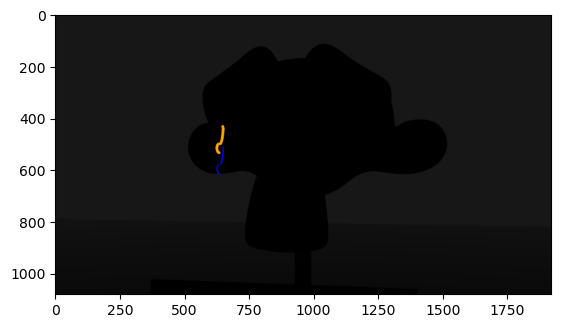

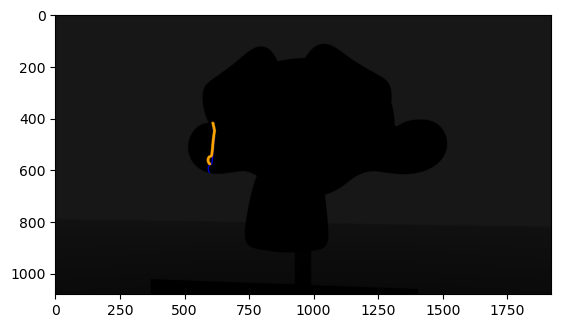

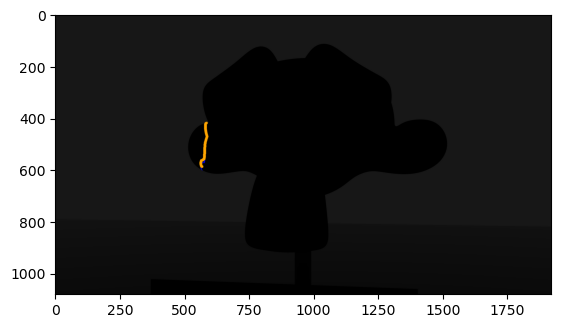

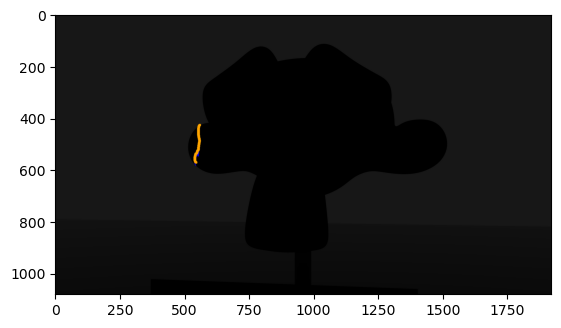

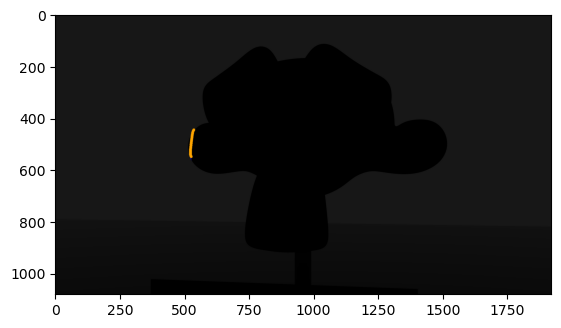

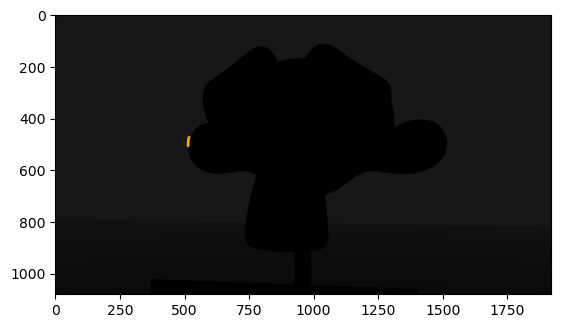

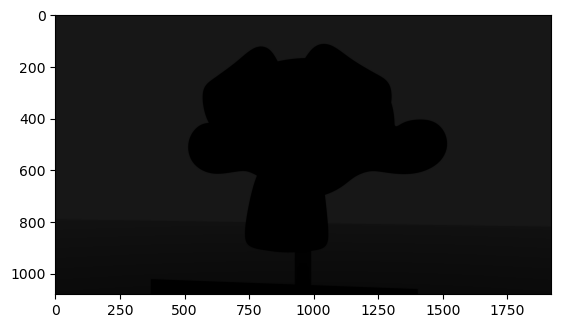

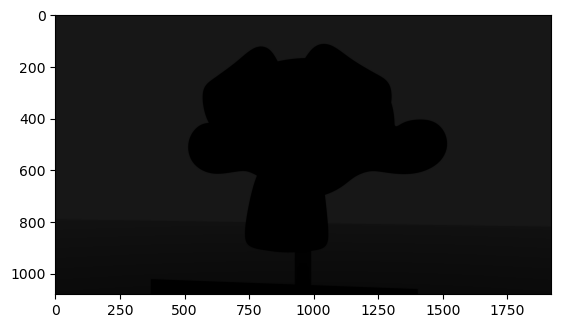

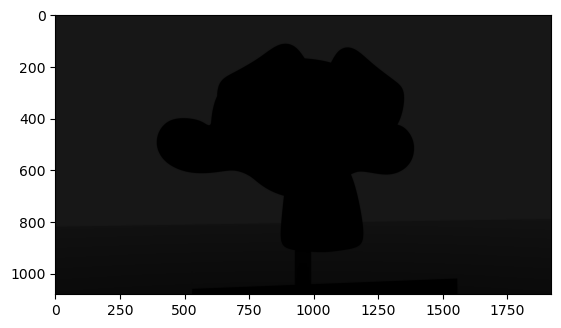

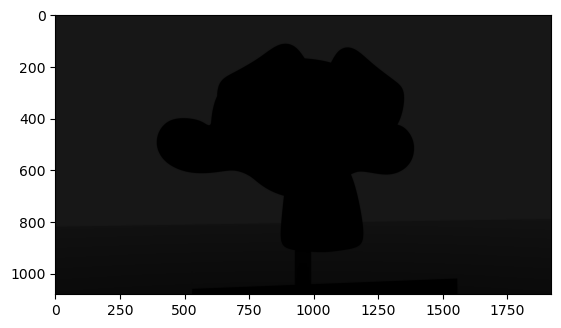

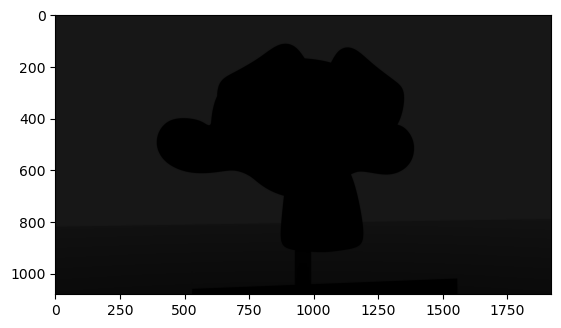

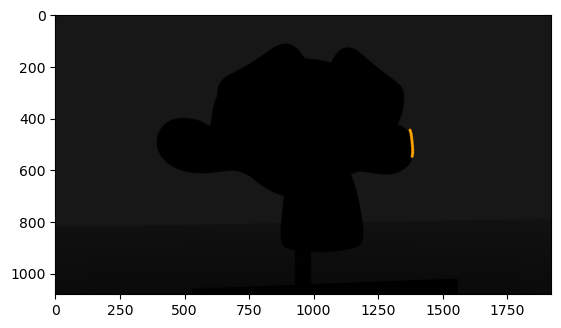

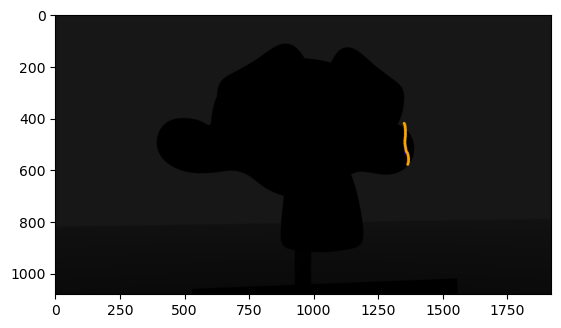

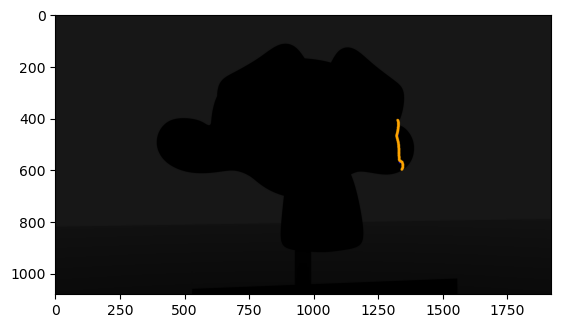

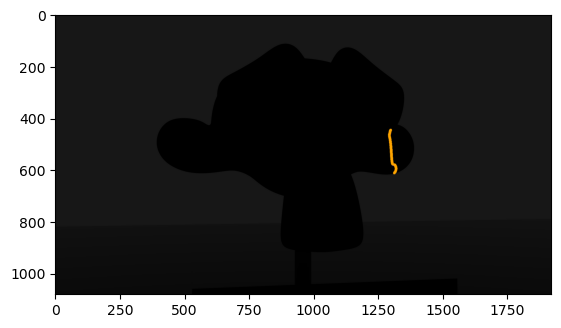

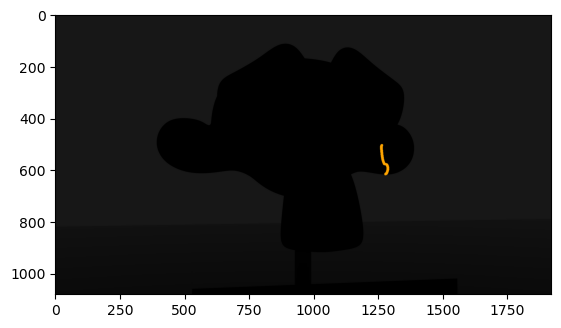

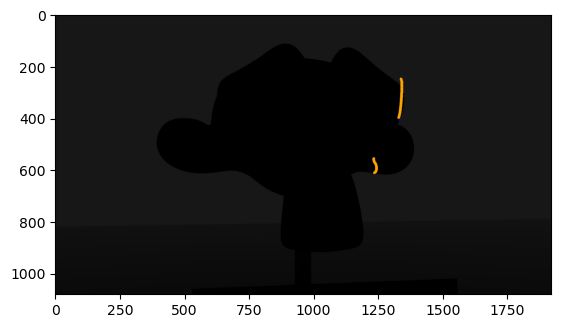

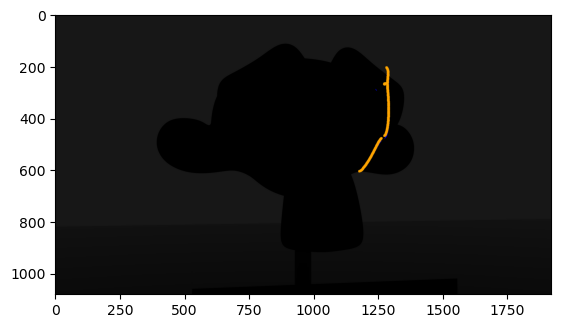

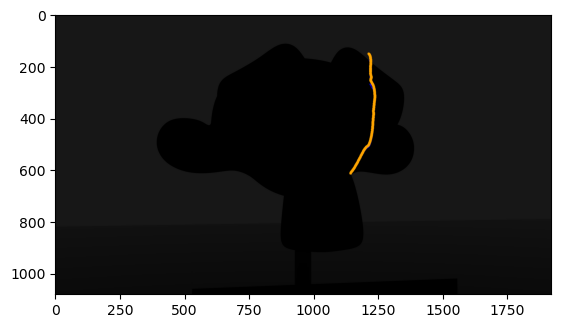

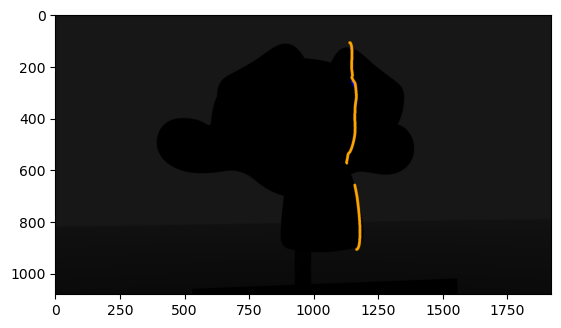

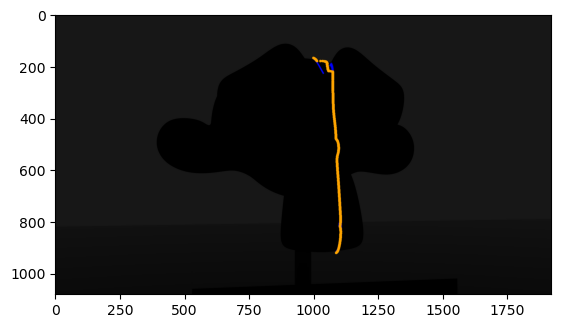

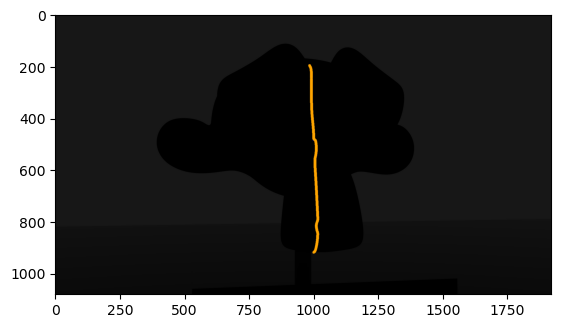

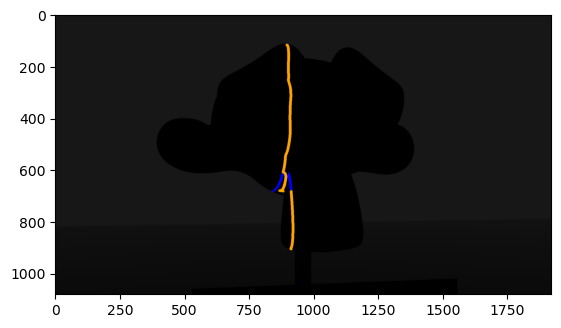

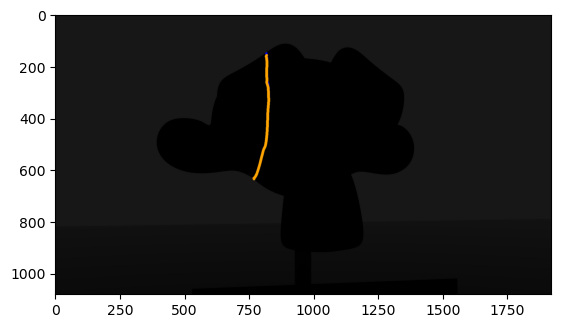

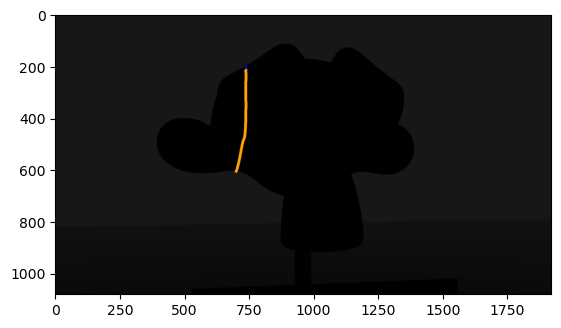

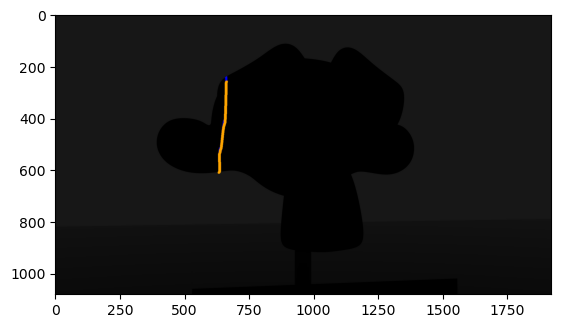

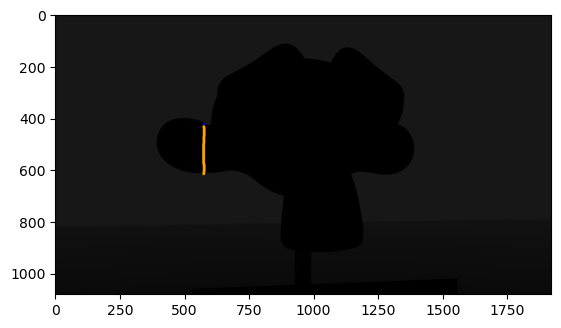

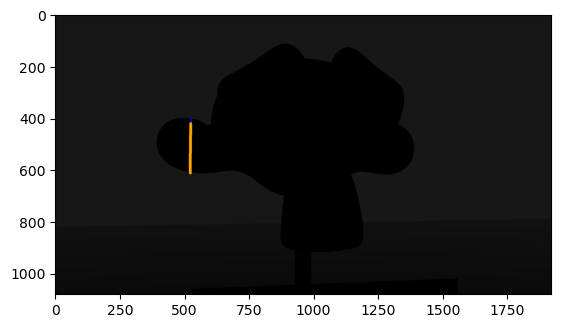

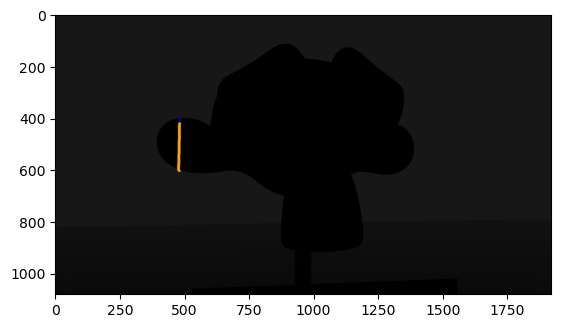

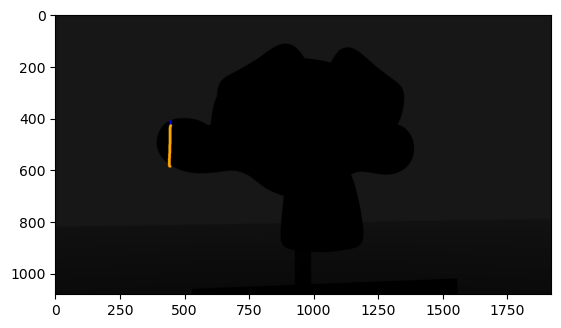

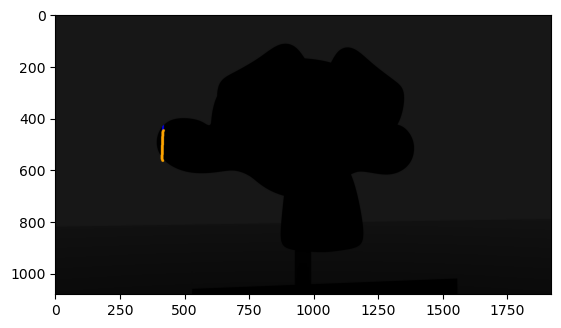

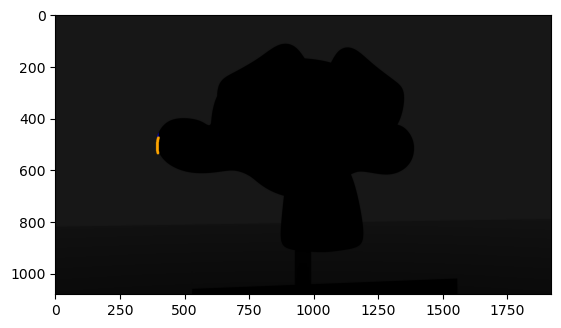

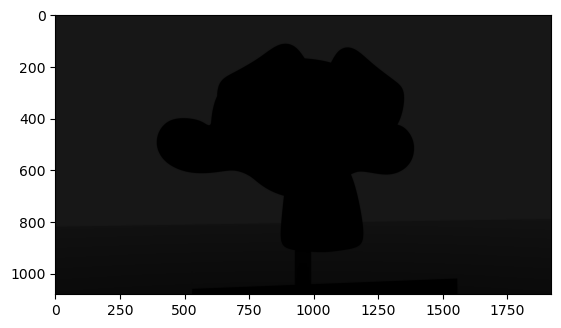

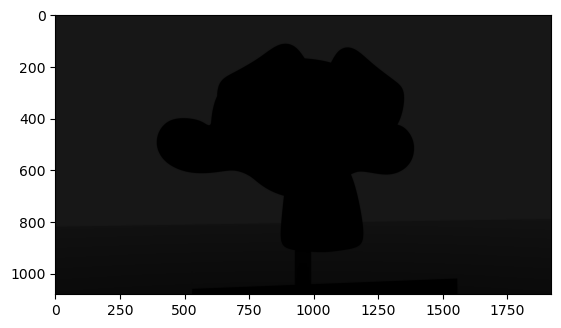

In [6]:
# Elle utilise la fonction getImgLine(fname) pour obtenir le canal rouge de l'image, puis cr√©e une liste redPoints pour stocker les points rouges.
def getReddAvg(fname):
    red = getImgLine(fname)
    redPoints = [[],[],[]]
# Elle utilise la fonction getImgLine(fname) pour obtenir le canal rouge de l'image, puis cr√©e une liste redPoints pour stocker les points rouges.
    for i, line in enumerate(red):
        for pixel in line:
            if pixel != 0:
                pixel = 1
        try:
            redPoints[0].append(np.average(range(1920), weights = line))
            redPoints[1].append(i)
            redPoints[2].append(1)
        except:
            pass
#         La fonction renvoie redPoints, qui contient les coordonn√©es des points rouges moyens.
    return redPoints #vraiment la meme chose que avant 
    #La fonction retourne redPoints, contenant les coordonn√©es moyennes des pixels rouges pour l'image.

# Elle parcourt 26 images dans le dossier sp√©cifi√© par path. Pour chaque image,
# elle utilise getReddAvg pour obtenir les points rouges moyens (redPoints).
# Ensuite, elle parcourt chaque point de l'√©piline droite correspondante (EplRight[l][1]), 
# utilise lineY pour calculer l'ordonn√©e correspondante √† la position x du point rouge, et stocke ces points dans pointsRight.
# Elle dessine √©galement des cercles color√©s sur l'image pour chaque point rouge d√©tect√©
# Enfin, elle affiche l'image modifi√©e avec les cercles.
# La fonction renvoie la liste points contenant les coordonn√©es des points droits correspondants pour les 26 images.
def eplRedPoints(path,EplRight):
    points = []
    for l in range(26):
        if l<10:
            strp = path + '000' + str(l) +'.png'
        else:
            strp = path + '00' + str(l) +'.png'
            
        redPoints = getReddAvg(strp)
        scan = cv.imread(strp)

        pointsRight = [[],[],[]]
        eplImg = EplRight[l][1]
        # print(strp)
        for i in range(len(eplImg[0])):
            try : 
                x = int(redPoints[0][i])
                y = int(lineY(eplImg[:,i],x))
                pointsRight[0].append(x)
                pointsRight[1].append(y)
                pointsRight[2].append(1)
                
                # color = tuple(np.random.randint(0,255,3).tolist())
                color = (255, 165, 0)
                scan = cv.circle(scan,(x,y),5,color,-1)
            except:
                pass
        points.append(pointsRight)
        plt.imshow(scan)
        plt.show()
    return points

#tout la meme mais en rouge 
pointsRight = eplRedPoints('scanRight/scan',epl)
pointsLeft = eplRedPoints('scanLeft/',epl)

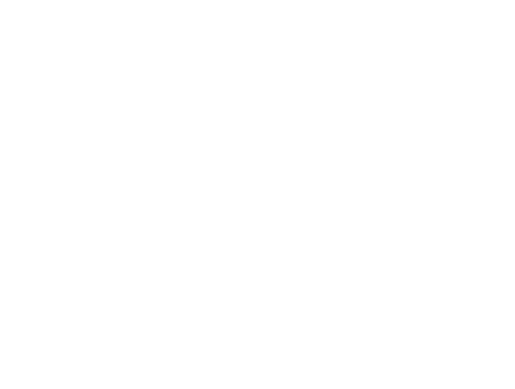

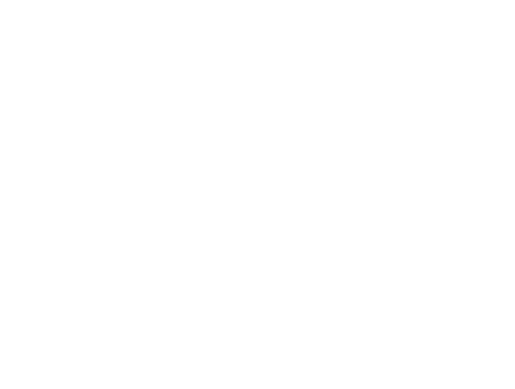

In [24]:
from mathutils import geometry as pygeo
from mathutils import Vector
import json
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def arrayToVector(p):
    return Vector((p[0],p[1],p[2]))

# Cette fonction prend les points des deux cam√©ras (pointsLeft et pointsRight) 
# et effectue plusieurs calculs g√©om√©triques pour trouver l'intersection des lignes de vue.
def getIntersection(pointsLeft,pointsRight):
    
    pL = np.array(pointsLeft)
    pR = np.array(pointsRight)
    #pointsLeft et pointsRight repr√©sentent les coordonn√©es homog√®nes des points observ√©s dans les images gauche et droite respectivement. Ils sont convertis en tableaux NumPy pour faciliter les calculs matriciels.
    
    camCenterRight = np.transpose(camWorldCenterRight)[0]
    camCenterLeft = np.transpose(camWorldCenterLeft)[0]
    #camWorldCenterRight et camWorldCenterLeft sont les coordonn√©es des centres des cam√©ras dans le monde 3D. Ces centres sont essentiels car les lignes de vue partent de ces points pour passer par les points projet√©s sur les images.
    
    # calcul du point sur l'object en applicant la pseudo-inverse de la camera sur le point trouv√© plus-haut
    #Cela permet de "ramener" les points projet√©s sur les images dans l'espace 3D par rapport √† chaque cam√©ra.
    
    leftObject = (np.linalg.pinv(camLeft) @ pL)
    rightObject = (np.linalg.pinv(camRight) @ pR) 
    
    # conversion des np.array en mathutils.Vector pour l'utilisation de la methode d'intersection
    
    leftEndVec = arrayToVector(leftObject)
    rightEndVec = arrayToVector(rightObject)
    
    leftStartVec = arrayToVector(camCenterLeft)
    rightStartVec = arrayToVector(camCenterRight)

    #leftStartVec et rightStartVec sont les points de d√©part des lignes de vue, c'est-√†-dire les centres des cam√©ras. leftEndVec et rightEndVec sont les points o√π ces lignes touchent l'objet.
    
    # affichage des lignes reliant centre √† point objet
    
    '''
    draw3DLine(camCenterLeft,leftObject)
    draw3DLine(camCenterRight,rightObject)
    plt.show()
    '''
    
    # utilisation de mathutils.geometry.intersect_line_line pour trouver l'intersection des lingnes passant par les 2 
    # points. 
    return pygeo.intersect_line_line(leftStartVec,leftEndVec,rightStartVec,rightEndVec)
#Cette ligne utilise la fonction intersect_line_line de mathutils.geometry pour trouver l'intersection entre deux lignes. Les lignes sont d√©finies par leurs points de d√©part (centres des cam√©ras) et leurs points finaux (points projet√©s sur l'objet dans l'espace 3D).
#Si les deux lignes se croisent, cette fonction renvoie le point d'intersection. Si elles ne se croisent pas exactement (ce qui est souvent le cas en raison de petites erreurs), elle renverra une estimation du point d'intersection le plus proche


# Cette fonction prend les coordonn√©es de d√©but et de fin d'une ligne en 3D et trace cette ligne en utilisant Matplotlib.
def draw3DLine(start, end):
    figure = plt.figure()
    ax = figure.add_subplot(111, projection='3d')
    
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    
    x_start, y_start, z_start = start
    x_end, y_end, z_end = end

    print("start = ({},{},{})".format(x_start, y_start, z_start))
    print("end = ({},{},{})\n".format(x_end, y_end, z_end))

    ax.scatter(x_start, y_start, z_start, c='r', marker='o')
    ax.plot([x_start, x_end], [y_start, y_end], [z_start, z_end])

    plt.show()


# Cette fonction effectue la triangulation en appelant getIntersection
# pour chaque paire de points de cam√©ra gauche et droite et retourne un tableau de points r√©sultants.
def getObjectPoint():
    point = [[],[],[]] #x, y et Z
    for l in range(26): #Pour chaque image l, les points correspondants de la cam√©ra gauche et de la cam√©ra droite sont extraits
        pointsLeft = np.array(epl[l][0])
        
        pointRight = np.array(pointsRight[l])
        for i in range(len(pointsLeft[0])):
            try:
                
                # calcul du point d'intersection sur l'objet -> on obtient une liste de vector
                intersection = getIntersection(pointsLeft[:,i],pointRight[:,i])
                # print(intersection)
                for inter in intersection:
                    inter *= 1000 #convertir unit√©
                    x,y,z = inter
                    point[0].append(x)
                    point[1].append(y)
                    point[2].append(z) #chaque point est extrait et mis dans une liste qui correspond
            except:
                pass
    return np.array(point)
    
# Cette fonction utilise Matplotlib pour afficher les points en 3D.
def drawPointObject(point):
    figure = plt.figure()
    ax = Axes3D(figure)
    
    ax.scatter3D(point[0,:], point[1,:], point[2,:], s=100, c='black', marker='x')     
    ax.view_init(-90, -70)

    # D√©finir la plage des axes pour mieux visualiser les points
    ax.set_xlim([min(point[0, :]), max(point[0, :])])
    ax.set_ylim([min(point[1, :]), max(point[1, :])])
    ax.set_zlim([min(point[2, :]), max(point[2, :])])

    plt.axis('off')
    plt.show()
    
# Cette fonction utilise Matplotlib pour afficher la surface en 3D √† l'aide de la m√©thode plot_trisurf.
def drawSurfaceObject(point):
    figure = plt.figure()
    ax = Axes3D(figure)
    ax.plot_trisurf(point[0,:],point[1,:],point[2,:])     

    ax.view_init(-95,-50)
    plt.axis('off')
    plt.show()
    
# Cette fonction prend les points triangules et les enregistre dans un fichier JSON nomm√© point.txt
def pointToJson(point):
    data = {'x':point[0,:].tolist(),'y':point[1,:].tolist(),'z':point[2,:].tolist()}
    with open('point.txt','+w') as file:
        json.dump(data,file)

# Appelez la fonction getObjectPoint pour obtenir les donn√©es de point
point = getObjectPoint()

# Appelez la fonction drawSurfaceObject pour afficher la surface
drawSurfaceObject(point)

# Appelez la fonction drawPointObject pour afficher les points
drawPointObject(point)

# Appelez la fonction pointToJson pour sauvegarder les points dans un fichier JSON
pointToJson(point)

In [8]:
import json
# Charger les donn√©es JSON depuis le fichier
with open('point.txt', 'r') as file:
    data = json.load(file)
# Afficher les donn√©es
#print("Coordonn√©es en X :", data['x'])
#print("Coordonn√©es en Y :", data['y'])
#print("Coordonn√©es en Z :", data['z'])

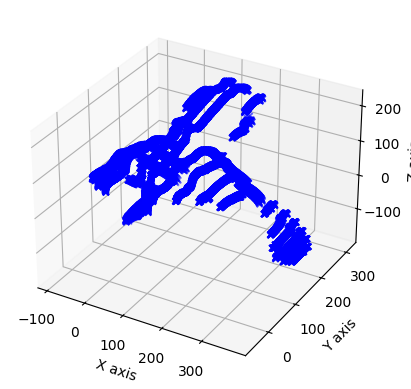

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot3DPoints(point):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(point[0, :], point[1, :], point[2, :], c='b', marker='x')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    plt.show()

# Utilisez la fonction plot3DPoints pour afficher tous les points
plot3DPoints(point)
